In [5]:
using JLD
using SparseArrays
using LinearAlgebra
using PyPlot
using PyCall
using TensorOperations
using FFTW
using DifferentialEquations
using SpecialFunctions
# using MKL
using QuadGK

gspec=pyimport("matplotlib.gridspec")
patches=pyimport("matplotlib.patches")
mpimg=pyimport("matplotlib.image")

include("./src/twm_simulate.jl")

simulate_twm (generic function with 1 method)

In [6]:
BLAS.set_num_threads(1)
println(BLAS.get_config())
println(Threads.nthreads())

LBTConfig([ILP64] libopenblas64_.dylib)
1


In [8]:
function gaussian_SH_pulse(zlist,σ)
    vect = [exp(-(z/σ)^2/2) for z in zlist]
    vect ./= norm(vect)
    return vect
end

gaussian_SH_pulse (generic function with 1 method)

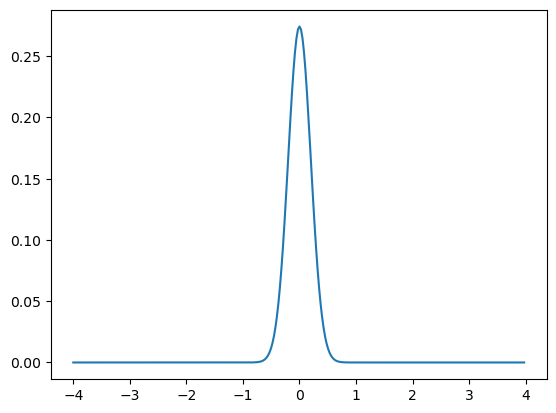

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x29c7dd3d0>

In [17]:
L = 8.0   # Size of the system. Open boundary condition.
n_half = 300   # Number of spatial bins per band. Total size of the MPS will be 2 times this number, because we have both signal and pump modes.
n_l = n_half*2   # Total number of spatial bins.
Δz = L/n_half   # Size of spatial bins
klist = [2*pi*l/L for l in -floor(Int64,n_half/2):1:ceil(Int64,n_half/2)-1]   # Wavespace coordinate
zlist = collect(range(-L/2,stop=L/2-Δz,length=n_half));   # Spatial coordinate
    
mmax = 4   # Maximum Fock space cutoff. 4 is usually enough.
n_fock = 4   # Fock space cutoff
χ = 20   # MPS bond dimension. Depends on the simulation.

β = 0.5   # GVD for the pump mode, relative to the signal GVD.
J = 1/(2*Δz^2)/(4pi^2)   # Nearnest-neighbor interactions between spatial bins. The value is proportionla to signal GVD.
V = 1/sqrt(Δz)   # Nonlinear coupling between local signal and pump bins.
Δ = 1.9   # Phase-mismatch between signal and pump

n_b = 0.02   # Number of pump photons
σ = 0.2   # Pump width in the temporal domain

flist = gaussian_SH_pulse(zlist,σ)   # Pump field distribution

flist_a = [i%2==1 ? flist[round(Int64,(i+1)/2)] : 0.0im for i in 1:n_l]
flist_a ./= norm(flist_a)
flist_b = [i%2==0 ? flist[round(Int64,(i)/2)] : 0.0im for i in 1:n_l]
flist_b ./= norm(flist_b)
α_a = 0.0
α_b = sqrt(n_b)

αlist_tot = α_a*flist_a+α_b*flist_b
plot(zlist,flist)

In [18]:
Γlist,λlist = coherent_twm(α_a,α_b,flist_a,flist_b,n_l,χ,mmax);

In [35]:
tmax = 0.1
nt = 10 # Steps
saveat = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 
th = 1e-10 # Truncation for SVD

Γset,λset,norm_list = simulate_twm!(Γlist,λlist,J,β,V,Δ,tmax,nt,saveat;threshold=th);

1
  2.234774 seconds (3.86 M allocations: 1.819 GiB, 18.85% gc time)
  1.824104 seconds (3.91 M allocations: 1.821 GiB, 9.20% gc time)
2
  1.825443 seconds (3.94 M allocations: 1.821 GiB, 9.10% gc time)
  1.877016 seconds (3.98 M allocations: 1.823 GiB, 9.17% gc time)
3
  1.883455 seconds (4.01 M allocations: 1.823 GiB, 9.15% gc time)
  1.998853 seconds (4.04 M allocations: 1.824 GiB, 10.46% gc time)
4
  1.966936 seconds (4.06 M allocations: 1.825 GiB, 10.69% gc time)
  1.972415 seconds (4.09 M allocations: 1.825 GiB, 10.12% gc time)
5
  1.927170 seconds (4.10 M allocations: 1.826 GiB, 8.07% gc time)
  1.959975 seconds (4.14 M allocations: 1.827 GiB, 9.09% gc time)
6
  1.997094 seconds (4.16 M allocations: 1.827 GiB, 9.61% gc time)
  1.936890 seconds (4.19 M allocations: 1.828 GiB, 8.56% gc time)
7
  1.861511 seconds (4.20 M allocations: 1.828 GiB, 8.15% gc time)
  1.854556 seconds (4.23 M allocations: 1.829 GiB, 7.88% gc time)
8
  1.879457 seconds (4.24 M allocations: 1.829 GiB, 8.32%

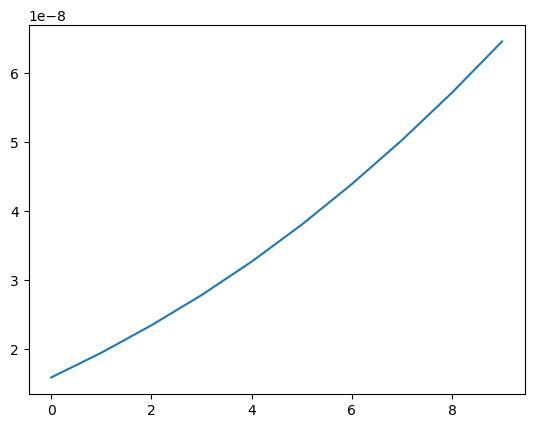

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2d2d1a2d0>

In [36]:
plot(1 .- norm_list)

In [22]:
Γfin = Γset[2]
λfin = λset[2];

In [26]:
mean(Γset[2],λset[2],51)

0.0 + 0.0im

In [28]:
g1(Γset[2],λset[2],50)

0.0 + 0.0im

In [38]:
αset_a = [[mean(Γset[si],λset[si],ci) for ci in 1:2:n_l] for si in eachindex(saveat)]
αset_b = [[mean(Γset[si],λset[si],ci) for ci in 2:2:n_l] for si in eachindex(saveat)]
g1set_a = [[g1(Γset[si],λset[si],ci) for ci in 1:2:n_l] for si in eachindex(saveat)]
g1set_b = [[g1(Γset[si],λset[si],ci) for ci in 2:2:n_l] for si in eachindex(saveat)];

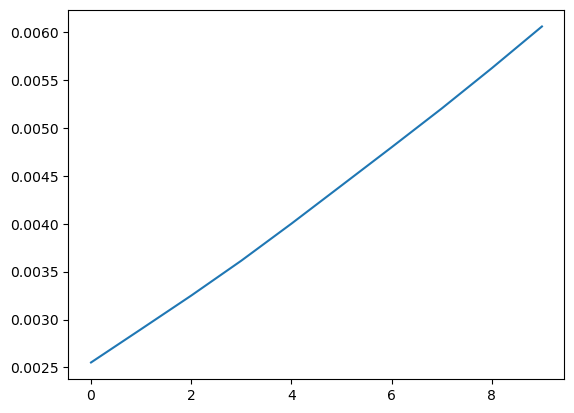

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2d2ce67d0>

In [39]:
plot([sum(g1a) for g1a in g1set_a])

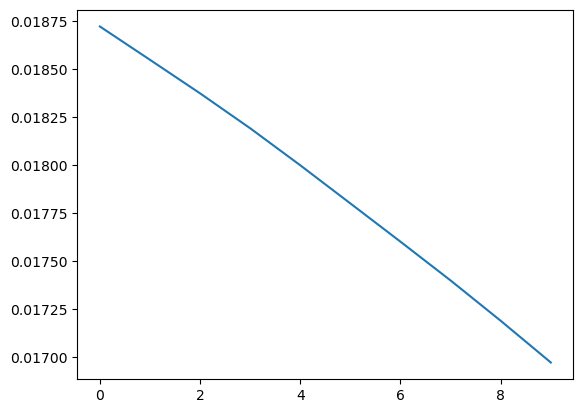

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2d2e62fd0>

In [40]:
plot([sum(g1b) for g1b in g1set_b])

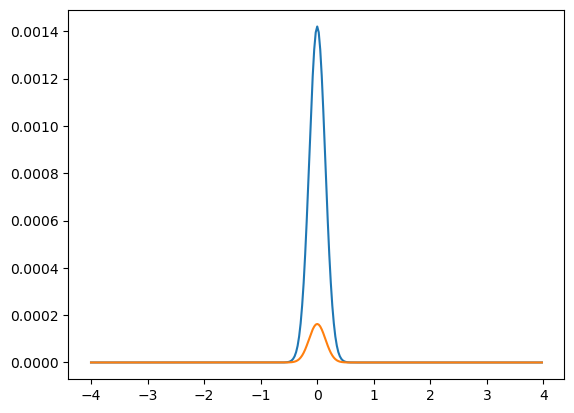

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2d2c98990>

In [34]:
plot(zlist,g1set_b[2],label="Pump")
plot(zlist,g1set_a[2],label="Signal")

In [ ]:
for (i,path) in enumerate(path_list)
    d = load(path)
    param_set = d["param_set"]
    g1set_a = d["g1set_a"]
    g1set_b = d["g1set_b"]
    tlist = vcat([0],param_set["saveat"].*param_set["tmax"]./param_set["nt"]);
    zlist = param_set["zlist"];
    α_b = param_set["α_b"]
    flist_b = param_set["flist_b"]
    nb0_list[i] = param_set["n_b"]
    
    tlist_list[i] = tlist
    zlist_list[i] = zlist
    
    g1set_a = vcat([zeros(length(zlist))],g1set_a)
    g1set_b = vcat([abs2.(α_b.*flist_b)[2:2:end]],g1set_b)
    
    namat = zeros(length(tlist),length(zlist))
    nbmat = zeros(length(tlist),length(zlist))
    
    for (ti,t) in enumerate(tlist)
        for (zi,z) in enumerate(zlist)
            namat[ti,zi] = real(g1set_a[ti][zi])
            nbmat[ti,zi] = real(g1set_b[ti][zi])
        end
    end
    
    namat_list[i] = namat
    nbmat_list[i] = nbmat
    
end

# Gaussian pulse PDC

In [3]:
function simulate_pdc(param_set,savepath)
    L = param_set["L"]
    n_l = param_set["n_l"]
    n_half = param_set["n_half"]
    mmax = param_set["mmax"]
    χ = param_set["χ"]
    J = param_set["J"]
    V = param_set["V"]
    β = param_set["β"]
    Δ = param_set["Δ"]
    α_a = param_set["α_a"]
    α_b = param_set["α_b"]
    flist_a = param_set["flist_a"]
    flist_b = param_set["flist_b"]
    nt = param_set["nt"]
    saveat = param_set["saveat"]
    th = param_set["th"]
    tmax = param_set["tmax"]
    
    Γlist,λlist = coherent_twm(α_a,α_b,flist_a,flist_b,n_l,χ,mmax);
    Γset,λset,norm_list = simulate_twm!(Γlist,λlist,J,β,V,Δ,tmax,nt,saveat;threshold=th);
    
    αset_a = [[mean(Γset[si],λset[si],ci) for ci in 1:2:n_l] for si in eachindex(saveat)]
    αset_b = [[mean(Γset[si],λset[si],ci) for ci in 2:2:n_l] for si in eachindex(saveat)]
    g1set_a = [[g1(Γset[si],λset[si],ci) for ci in 1:2:n_l] for si in eachindex(saveat)]
    g1set_b = [[g1(Γset[si],λset[si],ci) for ci in 2:2:n_l] for si in eachindex(saveat)]

    
    save(savepath,"param_set",param_set,"αset_a",αset_a,"αset_b",αset_b,"g1set_a",g1set_a,"g1set_b",g1set_b,"norm_list",norm_list)
end

simulate_pdc (generic function with 1 method)

In [4]:
function meson_energy(ξ;itr=50,λmax=1e3,λmin=0)
    f(λ) = λ + ξ -pi/(2sqrt(λ))
    
    λsup = λmax
    λinf = λmin
    for i in 1:itr
        λmid = (λsup + λinf)/2
        if f(λsup)*f(λmid)<0
            λinf = λmid
        else
            λsup = λmid
        end
    end
    return (λsup + λinf)/2
end

function broadband_pump(ξ,τ;λmax=1e4,rtol=1e-4)
    λm = meson_energy(ξ)
    f(λ) = exp(-im*(λ+λm)*τ)*2sqrt(λ)/(pi^2+4λ*(λ-ξ)^2)
    return abs2((1+pi/(4*λm^(3/2)))^(-1)+quadgk(f,0,λmax,rtol=rtol)[1])
end

broadband_pump (generic function with 1 method)

In [5]:
function gaussian_SH_pulse(zlist,σ)
    vect = [exp(-(z/σ)^2/2) for z in zlist]
    vect ./= norm(vect)
    return vect
end

gaussian_SH_pulse (generic function with 1 method)

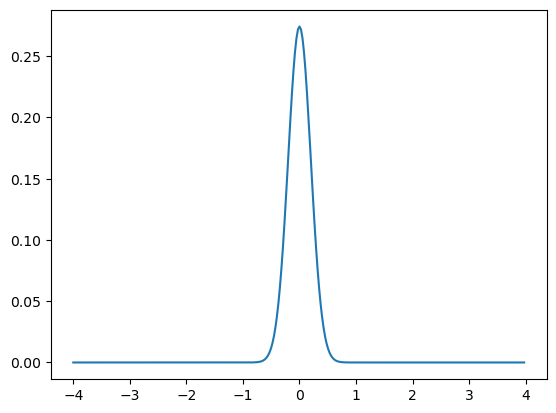

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f11e74c9f10>

In [14]:
L = 8.0
n_half = 300
n_l = n_half*2
Δz = L/n_half
klist = [2*pi*l/L for l in -floor(Int64,n_half/2):1:ceil(Int64,n_half/2)-1]
zlist = collect(range(-L/2,stop=L/2-Δz,length=n_half));

mmax = 4
n_fock = 4
χ = 60

β = 0.5
J = 1/(2*Δz^2)/(4pi^2)
V = 1/sqrt(Δz)
Δ = 1.9

n_b = 0.02
σ = 0.2

flist = gaussian_SH_pulse(zlist,σ)


flist_a = [i%2==1 ? flist[round(Int64,(i+1)/2)] : 0.0im for i in 1:n_l]
flist_a ./= norm(flist_a)
flist_b = [i%2==0 ? flist[round(Int64,(i)/2)] : 0.0im for i in 1:n_l]
flist_b ./= norm(flist_b)
α_a = 0.0
α_b = sqrt(n_b)

αlist_tot = α_a*flist_a+α_b*flist_b
plot(zlist,flist)

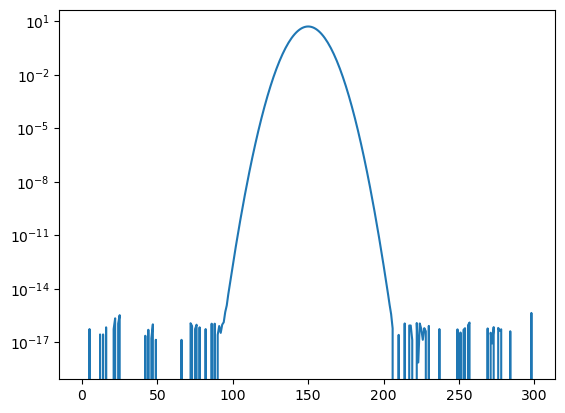

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f11ee1d1400>

In [15]:
semilogy(fftshift(fft(fftshift(flist))))

In [16]:
nt = 400
tmax = 2.8
saveat = [10*k for k in 1:40]
println(saveat)

th = 1e-10

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400]


1.0e-10

In [17]:
param_set = Dict([])
param_set["L"] = L
param_set["n_l"] = n_l
param_set["n_half"] = n_half
param_set["mmax"] = mmax
param_set["χ"] = χ
param_set["J"] = J
param_set["V"] = V
param_set["β"] = β
param_set["Δ"] = Δ
param_set["n_b"] = n_b
param_set["α_a"] = α_a
param_set["α_b"] = α_b
param_set["flist_a"] = flist_a
param_set["flist_b"] = flist_b
param_set["nt"] = nt
param_set["saveat"] = saveat
param_set["th"] = th
param_set["tmax"] = tmax
param_set["σ"] = σ
param_set["klist"] = klist
param_set["zlist"] = zlist;
param_set["n_fock"] = n_fock
param_set["αlist_tot"] = αlist_tot;
    

In [18]:
savepath="/data/yanagimotor/thesis/mps/gaussian-pulsed-PDC-n_b="*string(n_b)*"_chi="*string(χ)*"_nt="*string(nt)*"_mmax="*string(mmax)*"_σ="*string(σ)*"_tmax="*string(tmax)*"_beta="*string(β)*"_L="*string(L)*"_Delta="*string(Δ)*"_nhalf="*string(n_half)*".jld"
@time simulate_pdc(param_set,savepath);

1
  2.914357 seconds (7.68 M allocations: 13.369 GiB, 31.71% gc time)
  1.789195 seconds (8.85 M allocations: 13.399 GiB)
2
  1.843891 seconds (9.37 M allocations: 13.412 GiB)
  2.457909 seconds (9.85 M allocations: 13.424 GiB, 13.74% gc time)
3
  1.138075 seconds (10.15 M allocations: 13.348 GiB)
  1.196407 seconds (10.56 M allocations: 13.442 GiB)
4
  1.504750 seconds (10.82 M allocations: 12.062 GiB, 21.60% gc time)
  1.158211 seconds (11.32 M allocations: 12.301 GiB)
5
  1.255820 seconds (11.69 M allocations: 13.470 GiB)
  1.620895 seconds (12.04 M allocations: 13.478 GiB)
6
  2.088782 seconds (12.36 M allocations: 13.486 GiB)
  2.153137 seconds (12.84 M allocations: 13.497 GiB)
7
  1.796538 seconds (13.16 M allocations: 13.440 GiB, 37.05% gc time)
  1.216816 seconds (13.61 M allocations: 13.517 GiB)
8
  1.290078 seconds (13.94 M allocations: 13.525 GiB)
  1.304465 seconds (14.50 M allocations: 13.539 GiB)
9
  1.927034 seconds (14.85 M allocations: 13.548 GiB)
  2.169279 seconds (1

  1.215649 seconds (34.68 M allocations: 14.040 GiB)
73
  1.219237 seconds (34.74 M allocations: 14.042 GiB)
  2.568239 seconds (34.83 M allocations: 14.044 GiB, 52.82% gc time)
74
  1.226286 seconds (34.89 M allocations: 13.978 GiB)
  1.222290 seconds (35.05 M allocations: 14.050 GiB)
75
  1.227361 seconds (35.07 M allocations: 14.050 GiB)
  1.225678 seconds (35.20 M allocations: 14.053 GiB)
76
  1.274559 seconds (35.28 M allocations: 14.055 GiB)
  2.763552 seconds (35.36 M allocations: 14.057 GiB, 55.29% gc time)
77
  1.223222 seconds (35.41 M allocations: 13.983 GiB)
  1.246850 seconds (35.50 M allocations: 14.060 GiB)
78
  1.210815 seconds (35.56 M allocations: 14.062 GiB)
  1.215919 seconds (35.65 M allocations: 14.064 GiB)
79
  1.212471 seconds (35.72 M allocations: 14.066 GiB)
  1.215531 seconds (35.88 M allocations: 14.070 GiB)
80
  2.798294 seconds (35.89 M allocations: 13.985 GiB, 55.45% gc time)
  1.251508 seconds (36.00 M allocations: 14.073 GiB)
81
  1.218022 seconds (36.0

  1.239546 seconds (46.69 M allocations: 14.338 GiB)
  1.223683 seconds (46.77 M allocations: 14.340 GiB)
145
 11.662449 seconds (46.80 M allocations: 14.287 GiB, 89.19% gc time)
  1.216318 seconds (46.92 M allocations: 14.344 GiB)
146
  1.237980 seconds (47.00 M allocations: 14.346 GiB)
  1.212349 seconds (47.11 M allocations: 14.349 GiB)
147
  1.401006 seconds (47.20 M allocations: 14.351 GiB)
  1.384830 seconds (47.37 M allocations: 14.356 GiB)
148
  1.277302 seconds (47.39 M allocations: 14.355 GiB)
  3.186168 seconds (47.49 M allocations: 14.358 GiB, 60.97% gc time)
149
  1.230429 seconds (47.55 M allocations: 14.336 GiB)
  1.215313 seconds (47.65 M allocations: 14.362 GiB)
150
  1.239449 seconds (47.72 M allocations: 14.364 GiB)
  1.230413 seconds (47.83 M allocations: 14.366 GiB)
151
  1.295162 seconds (47.90 M allocations: 14.368 GiB)
  1.220807 seconds (48.00 M allocations: 14.371 GiB)
152
  2.975284 seconds (48.05 M allocations: 14.353 GiB, 58.31% gc time)
  1.261181 seconds 

  1.237818 seconds (59.71 M allocations: 14.661 GiB)
216
  1.229655 seconds (59.80 M allocations: 14.664 GiB)
  1.239933 seconds (59.91 M allocations: 14.666 GiB)
217
  2.506589 seconds (59.98 M allocations: 14.591 GiB, 50.32% gc time)
  1.306887 seconds (60.08 M allocations: 14.671 GiB)
218
  1.256391 seconds (60.15 M allocations: 14.672 GiB)
  1.257695 seconds (60.26 M allocations: 14.675 GiB)
219
 10.290125 seconds (60.35 M allocations: 14.627 GiB, 87.57% gc time)
  1.237492 seconds (60.52 M allocations: 14.682 GiB)
220
  1.351771 seconds (60.51 M allocations: 14.681 GiB)
  1.228512 seconds (60.65 M allocations: 14.685 GiB)
221
  1.253762 seconds (60.74 M allocations: 14.687 GiB)
 10.593025 seconds (60.85 M allocations: 14.690 GiB, 88.27% gc time)
222
  1.255002 seconds (60.92 M allocations: 14.692 GiB)
  1.224334 seconds (61.03 M allocations: 14.694 GiB)
223
  1.254624 seconds (61.11 M allocations: 14.696 GiB)
  2.683426 seconds (61.24 M allocations: 14.699 GiB, 53.75% gc time)
224

  4.414327 seconds (73.46 M allocations: 15.003 GiB, 70.70% gc time)
288
  1.232129 seconds (73.53 M allocations: 14.987 GiB)
  1.260754 seconds (73.67 M allocations: 15.008 GiB)
289
  1.344491 seconds (73.77 M allocations: 15.010 GiB)
  1.246960 seconds (73.87 M allocations: 15.013 GiB)
290
  1.247924 seconds (73.94 M allocations: 15.015 GiB)
  1.236860 seconds (74.05 M allocations: 15.017 GiB)
291
  1.338323 seconds (74.12 M allocations: 15.019 GiB)
 18.493341 seconds (74.28 M allocations: 15.024 GiB, 93.03% gc time)
292
  1.257094 seconds (74.31 M allocations: 15.024 GiB)
  1.263519 seconds (74.43 M allocations: 15.027 GiB)
293
  1.244327 seconds (74.51 M allocations: 15.029 GiB)
  1.282669 seconds (74.66 M allocations: 15.033 GiB)
294
  1.316913 seconds (74.73 M allocations: 15.034 GiB)
  1.253797 seconds (74.82 M allocations: 15.037 GiB)
295
  1.306948 seconds (74.90 M allocations: 15.039 GiB)
 19.522393 seconds (75.01 M allocations: 15.030 GiB, 92.87% gc time)
296
  1.265291 seco

  1.316825 seconds (87.51 M allocations: 15.352 GiB)
360
  1.292668 seconds (87.58 M allocations: 15.354 GiB)
  5.511519 seconds (87.72 M allocations: 15.357 GiB, 75.51% gc time)
361
  1.243334 seconds (87.82 M allocations: 15.346 GiB)
  1.326644 seconds (87.96 M allocations: 15.363 GiB)
362
  1.298708 seconds (88.05 M allocations: 15.365 GiB)
  1.313130 seconds (88.19 M allocations: 15.369 GiB)
363
  1.314399 seconds (88.26 M allocations: 15.371 GiB)
  1.324492 seconds (88.39 M allocations: 15.374 GiB)
364
  1.263894 seconds (88.38 M allocations: 15.373 GiB)
  5.369833 seconds (88.48 M allocations: 15.376 GiB, 75.25% gc time)
365
  1.291342 seconds (88.57 M allocations: 15.363 GiB)
  1.249355 seconds (88.73 M allocations: 15.382 GiB)
366
  1.270306 seconds (88.83 M allocations: 15.385 GiB)
  1.268057 seconds (88.95 M allocations: 15.388 GiB)
367
  1.260937 seconds (89.02 M allocations: 15.389 GiB)
  1.293679 seconds (89.13 M allocations: 15.392 GiB)
368
  1.274213 seconds (89.19 M all

In [11]:
path_list = [
    "/data/yanagimotor/thesis/mps/gaussian-pulsed-PDC-n_b=0.01_chi=60_nt=400_mmax=4_σ=1.0_tmax=2.0_beta=0.5_L=12.0_Delta=1.9n_half=300.jld",
    "/data/yanagimotor/thesis/mps/gaussian-pulsed-PDC-n_b=0.1_chi=60_nt=400_mmax=4_σ=1.0_tmax=2.0_beta=0.5_L=12.0_Delta=1.9n_half=300.jld",
#     "/data/yanagimotor/thesis/mps/gaussian-pulsed-PDC-n_b=0.3_chi=60_nt=400_mmax=4_σ=1.0_tmax=2.0_beta=0.5_L=12.0_Delta=1.9n_half=300.jld",
    "/data/yanagimotor/thesis/mps/gaussian-pulsed-PDC-n_b=1.0_chi=100_nt=400_mmax=4_σ=1.0_tmax=2.0_beta=0.5_L=12.0_Delta=1.9n_half=300.jld",
    "/data/yanagimotor/thesis/mps/gaussian-pulsed-PDC-n_b=3.0_chi=200_nt=400_mmax=4_σ=1.0_tmax=2.0_beta=0.5_L=12.0_Delta=1.9n_half=300.jld"
]

namat_list = Array{Matrix{Float64}}(undef,length(path_list))
nbmat_list = Array{Matrix{Float64}}(undef,length(path_list))
zlist_list = Array{Vector{Float64}}(undef,length(path_list))
tlist_list = Array{Vector{Float64}}(undef,length(path_list))
nb0_list = zeros(length(path_list))

for (i,path) in enumerate(path_list)
    d = load(path)
    param_set = d["param_set"]
    g1set_a = d["g1set_a"]
    g1set_b = d["g1set_b"]
    tlist = vcat([0],param_set["saveat"].*param_set["tmax"]./param_set["nt"]);
    zlist = param_set["zlist"];
    α_b = param_set["α_b"]
    flist_b = param_set["flist_b"]
    nb0_list[i] = param_set["n_b"]
    
    tlist_list[i] = tlist
    zlist_list[i] = zlist
    
    g1set_a = vcat([zeros(length(zlist))],g1set_a)
    g1set_b = vcat([abs2.(α_b.*flist_b)[2:2:end]],g1set_b)
    
    namat = zeros(length(tlist),length(zlist))
    nbmat = zeros(length(tlist),length(zlist))
    
    for (ti,t) in enumerate(tlist)
        for (zi,z) in enumerate(zlist)
            namat[ti,zi] = real(g1set_a[ti][zi])
            nbmat[ti,zi] = real(g1set_b[ti][zi])
        end
    end
    
    namat_list[i] = namat
    nbmat_list[i] = nbmat
    
end

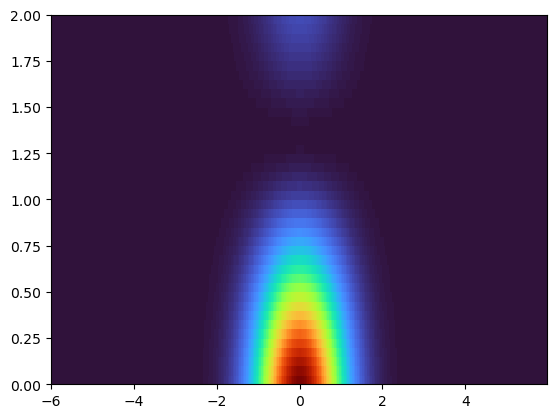

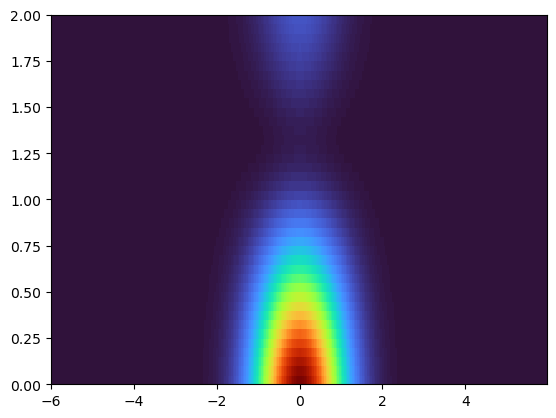

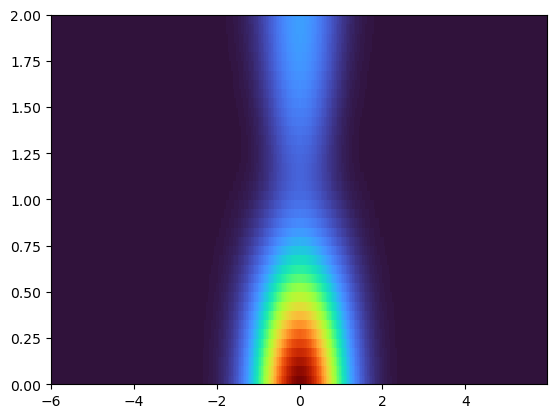

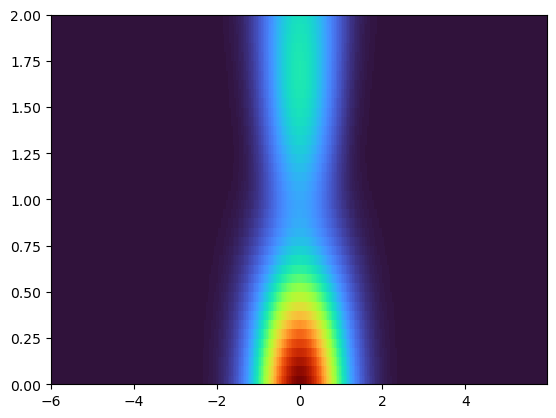

In [12]:
for (nb0i,nb0) in enumerate(nb0_list)
#     plot(tlist_list[nb0i],sum(namat_list[nb0i],dims=2)./2 ./nb0,label=L"$n_b="*string(nb0)*L"$")
    pcolormesh(zlist_list[nb0i],tlist_list[nb0i],nbmat_list[nb0i],cmap="turbo")
    figure()
end


In [19]:
for (nb0i,nb0) in enumerate(nb0_list)
    plot(tlist_list[nb0i],sum(namat_list[nb0i],dims=2)./2 ./nb0,label=L"$n_b="*string(nb0)*L"$")
end

plot(tlist_list[1],1 .-broadband_pump.(1.9,tlist_list[1]),"--",label="Single-photon-pumped PDC")
legend()
xlabel("Time")
ylabel("Conversion efficiency")

LoadError: UndefVarError: nb0_list not defined

In [22]:
d = load(savepath)
g1set_a = d["g1set_a"]
g1set_b = d["g1set_b"]
norm_list = d["norm_list"]
param_set = d["param_set"]
nalist = [sum(ls) for ls in g1set_a];
nblist = [sum(ls) for ls in g1set_b];
tlist = param_set["saveat"].*param_set["tmax"]./param_set["nt"];
zlist = param_set["zlist"];

namat = zeros(length(tlist),length(zlist))
nbmat = zeros(length(tlist),length(zlist))
for (ti,t) in enumerate(tlist)
    for (zi,z) in enumerate(zlist)
        namat[ti,zi] = real(g1set_a[ti][zi])
        nbmat[ti,zi] = real(g1set_b[ti][zi])
    end
end


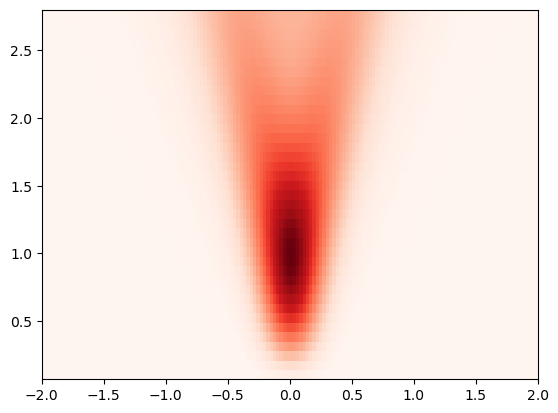

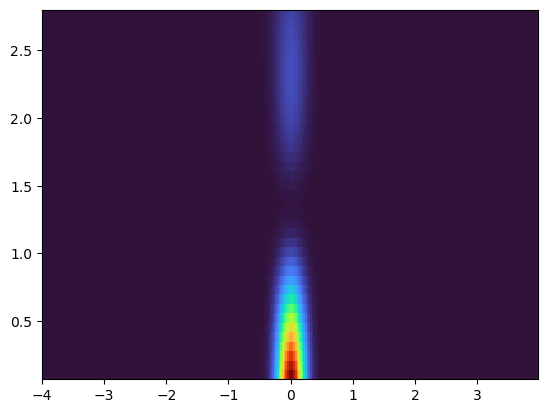

PyObject <matplotlib.collections.QuadMesh object at 0x7f11e746c820>

In [23]:
pcolormesh(zlist,tlist,namat,cmap="Reds")
xlim(-2,2)
figure()
pcolormesh(zlist,tlist,nbmat,cmap="turbo")

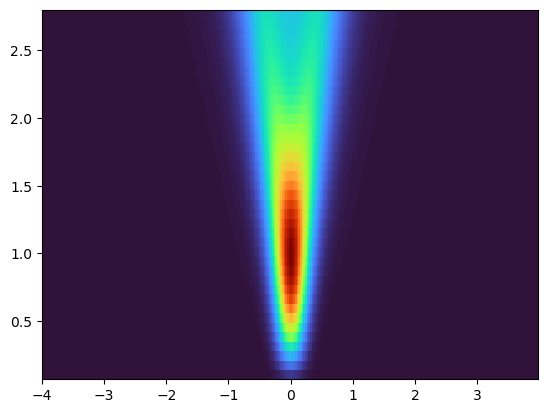

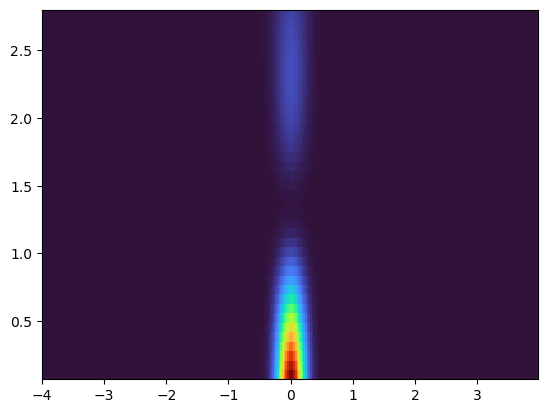

PyObject <matplotlib.collections.QuadMesh object at 0x7f11ede6c190>

In [24]:
pcolormesh(zlist,tlist,namat,cmap="turbo")
figure()
pcolormesh(zlist,tlist,nbmat,cmap="turbo")

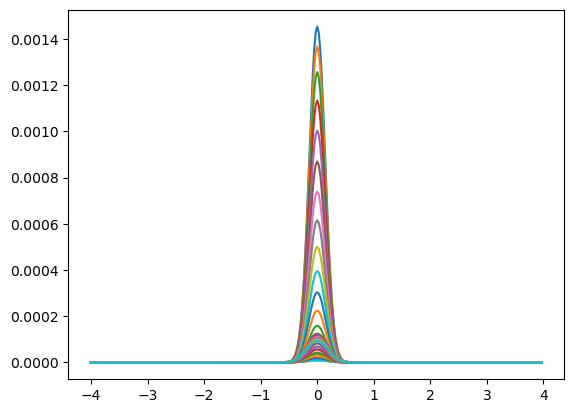

In [25]:



figure()

for g1 in g1set_b
    plot(zlist,real.(g1))
end

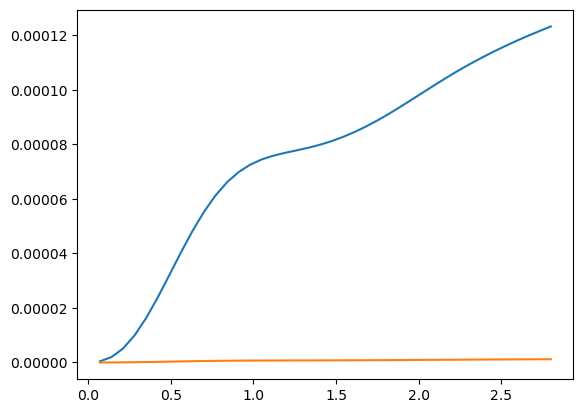

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f11edf0d8b0>

In [26]:
plot(tlist,1 .-(nalist./2 .+nblist)./param_set["n_b"])
plot(tlist,1 .-norm_list)
# ylim(0,1.0)

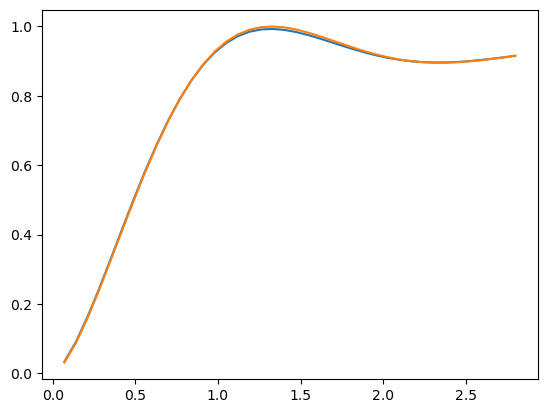

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f11ee1b4700>

In [27]:
plot(tlist,nalist./2 ./param_set["n_b"])
plot(tlist,1 .-broadband_pump.(Δ,tlist))


In [15]:
tlist

20-element Vector{Float64}:
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0
 1.1
 1.2
 1.3
 1.4
 1.5
 1.6
 1.7
 1.8
 1.9
 2.0

In [17]:
savepath 

"/data/yanagimotor/thesis/mps/gaussian-pulsed-PDC-n_b=1.0_chi=200_nt=400_mmax=4_σ=0.2_tmax=2.8_beta=0.5_L=8.0_Delta=1.9_nhalf=300.jld"

In [21]:
savepath 

"/data/yanagimotor/thesis/mps/gaussian-pulsed-PDC-n_b=0.02_chi=60_nt=400_mmax=4_σ=0.2_tmax=2.8_beta=0.5_L=8.0_Delta=1.9_nhalf=300.jld"